Reference : https://www.kaggle.com/manabendrarout/transformers-classifier-method-starter-train

### Imports

In [1]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from tqdm.auto import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np
import os
import random
import gc
import cv2
import glob
gc.enable()
pd.set_option('display.max_columns', None)

# Visialisation
import matplotlib.pyplot as plt
%matplotlib inline

# Image Aug
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

# Deep Learning
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR, CosineAnnealingLR
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#Metrics
from sklearn.metrics import mean_squared_error

# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

# Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: cuda


In [2]:
csv_dir = '/mnt/hdd1/wearly/kaggle/petfinder/data/'
train_dir = '/mnt/hdd1/wearly/kaggle/petfinder/data/train/'
test_dir = '/mnt/hdd1/wearly/kaggle/petfinder/data/test/'

train_file_path = '/mnt/hdd1/wearly/kaggle/petfinder/data/datasets/pawpular-folds/train_5folds.csv'
sample_sub_file_path = os.path.join(csv_dir, 'sample_submission.csv')

print(f'Train file : {train_file_path}')
print(f'Train file : {sample_sub_file_path}')
      

Train file : /mnt/hdd1/wearly/kaggle/petfinder/data/datasets/pawpular-folds/train_5folds.csv
Train file : /mnt/hdd1/wearly/kaggle/petfinder/data/sample_submission.csv


In [3]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(sample_sub_file_path)

def return_filpath(name, folder=train_dir):
    path = os.path.join(folder, f'{name}.jpg')
    return path

In [4]:
train_df['image_path'] = train_df['Id'].apply(lambda x: return_filpath(x))
test_df['image_path'] = test_df['Id'].apply(lambda x: return_filpath(x, folder=test_dir))

In [5]:
target = ['Pawpularity']
not_features = ['Id', 'kfold', 'image_path', 'Pawpularity']
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)

['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']


## CFG

In [6]:
TRAIN_FOLDS = [0,1,2,3,4]

params = {
    'model': 'vit_large_patch32_384',
    'dense_features': features,
    'pretrained': True,
    'inp_channels': 3,
    'im_size': 384,
    'device': device,
    'lr': 1e-5,
    'weight_decay': 1e-6,
    'batch_size': 32,
    'num_workers' : 0,
    'epochs': 20,
    'out_features': 1,
    'dropout': 0.2,
    'num_fold': len(TRAIN_FOLDS),
    'mixup': False,
    'mixup_alpha': 1.0,
    'scheduler_name': 'CosineAnnealingWarmRestarts',
    'T_0': 5,
    'T_max': 5,
    'T_mult': 1,
    'min_lr': 1e-7,
    'max_lr': 1e-4
}

In [7]:
print(params)

{'model': 'vit_large_patch32_384', 'dense_features': ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'], 'pretrained': True, 'inp_channels': 3, 'im_size': 384, 'device': device(type='cuda'), 'lr': 1e-05, 'weight_decay': 1e-06, 'batch_size': 32, 'num_workers': 0, 'epochs': 20, 'out_features': 1, 'dropout': 0.2, 'num_fold': 5, 'mixup': False, 'mixup_alpha': 1.0, 'scheduler_name': 'CosineAnnealingWarmRestarts', 'T_0': 5, 'T_max': 5, 'T_mult': 1, 'min_lr': 1e-07, 'max_lr': 0.0001}


## 1. Train Augmentations

In [8]:
def get_train_transforms(DIM = params['im_size']):
    return albumentations.Compose(
        [
            albumentations.Resize(DIM,DIM),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2,
                val_shift_limit=0.2, p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.5
            ),
            ToTensorV2(p=1.0),
        ]
    )

## 2. Mixup

In [9]:
def mixup_data(x, z, y, params):
    if params['mixup_alpha'] > 0:
        lam = np.random.beta(
            params['mixup_alpha'], params['mixup_alpha']
        )
    else:
        lam = 1

    batch_size = x.size()[0]
    if params['device'].type == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_z = lam * z + (1 - lam) * z[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, mixed_z, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)    

### 3.Valid Augmentations

In [10]:
def get_valid_transforms(DIM= params['im_size']):
    return albumentations.Compose(
        [
            albumentations.Resize(DIM,DIM),
            albumentations.Normalize(
                mean = [0.485,0.456,0.406],
                std = [0.229,0.224,0.225],
            ),
            ToTensorV2(p=1.0)
        ]
    )

## Dataset

In [11]:
class CuteDataset(Dataset):
    def __init__(self, images_filepaths, dense_features, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.dense_features = dense_features
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        dense = self.dense_features[idx, :]
        label = torch.tensor(self.targets[idx]).float()
        return image, dense, label

### 1. Visualize Some Examples

In [12]:
X_train = train_df['image_path']
X_train_dense = train_df[params['dense_features']]
y_train = train_df['Pawpularity']
train_dataset = CuteDataset(
    images_filepaths=X_train.values,
    dense_features=X_train_dense.values,
    targets=y_train.values,
    transform=get_train_transforms()
)

In [13]:
def show_image(train_dataset=train_dataset, inline=4):
    plt.figure(figsize=(20,10))
    for i in range(inline):
        rand = random.randint(0, len(train_dataset))
        image, dense, label = train_dataset[rand]
        plt.subplot(1, inline, i%inline +1)
        plt.axis('off')
        plt.imshow(image.permute(2, 1, 0))
        plt.title(f'Pawpularity: {label}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


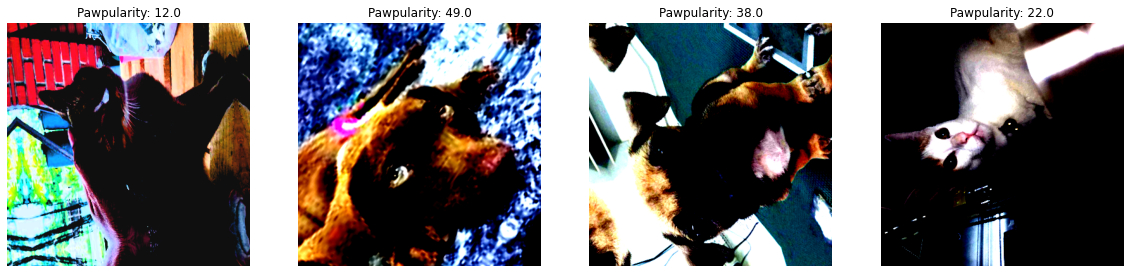

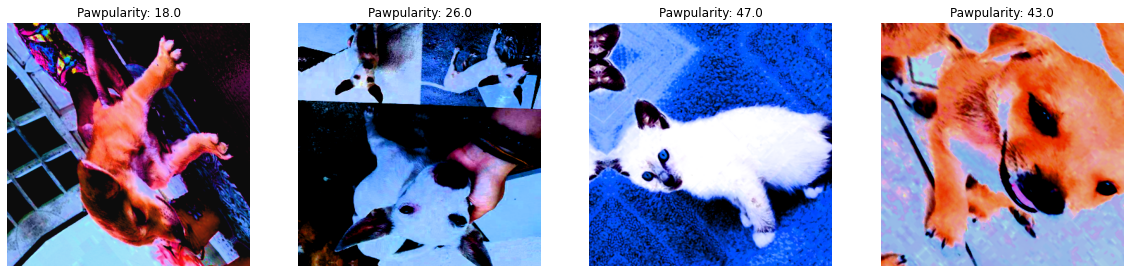

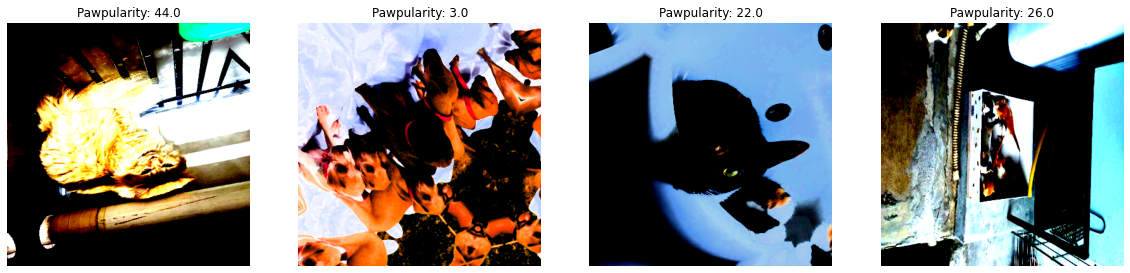

In [14]:
for i in range(3):
    show_image(inline=4)

In [15]:
del X_train, X_train_dense, y_train, train_dataset


## Metrics

In [16]:
def usr_rmse_score(output,target):
    y_pred = torch.sigmoid(output).cpu()
    y_pred = y_pred.detach().numpy()*100
    target = target.cpu()*100
    
    return mean_squared_error(target, y_pred, squared=False)

In [17]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

## Scheduler¶
Scheduler is essentially an function that changes our learning rate over epochs/steps. But why do we need to do that?

The first reason is that our network may become stuck in either saddle points or local minima, and the low learning rate may not be sufficient to break out of the area and descend into areas of the loss landscape with lower loss.
Secondly, our model and optimizer may be very sensitive to our initial learning rate choice. If we make a poor initial choice in learning rate, our model may be stuck from the very start.
Instead, we can use Schedulers and specifically Cyclical Learning Rates(CLR) to oscillate our learning rate between upper and lower bounds, enabling us to:

Have more freedom in our initial learning rate choices.
Break out of saddle points and local minima.
In practice, using CLRs leads to far fewer learning rate tuning experiments along with near identical accuracy to exhaustive hyperparameter tuning.

In [18]:
def get_scheduler(optimizer, scheduler_params=params):
    if scheduler_params['scheduler_name'] == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=scheduler_params['T_0'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    elif scheduler_params['scheduler_name'] == 'OneCycleLR':
        scheduler = OneCycleLR(
            optimizer,
            max_lr=scheduler_params['max_lr'],
            steps_per_epoch=int(((scheduler_params['num_fold']-1) * train_df.shape[0]) / (scheduler_params['num_fold'] * scheduler_params['batch_size'])) + 1,
            epochs=scheduler_params['epochs'],
        )

    elif scheduler_params['scheduler_name'] == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=scheduler_params['T_max'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    return scheduler

## CNN Model

In [19]:
class PetNet(nn.Module):
    def __init__(self, model_name=params['model'], out_features=params['out_features'], inp_channels=params['inp_channels'],
                 pretrained=params['pretrained'], num_dense=len(params['dense_features'])):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, 128)
        self.fc = nn.Sequential(
            nn.Linear(128 + num_dense, 64),
            nn.ReLU(),
            nn.Linear(64, out_features)
        )
        self.dropout = nn.Dropout(params['dropout'])
    
    def forward(self, image, dense):
        embeddings = self.model(image)
        x = self.dropout(embeddings)
        x = torch.cat([x, dense], dim=1)
        output = self.fc(x)
        return output

## Train and Valid functions

### 1. Train Functions

In [20]:
def train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler=None):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    
    for i, (images, dense, target) in enumerate(stream, start=1):
        if params['mixup']:
            images, dense, target_a, target_b, lam = mixup_data(images, dense, target.view(-1, 1), params)
            images = images.to(params['device'], dtype=torch.float)
            dense = dense.to(params['device'], dtype=torch.float)
            target_a = target_a.to(params['device'], dtype=torch.float)
            target_b = target_b.to(params['device'], dtype=torch.float)
        else:
            images = images.to(params['device'], non_blocking=True)
            dense = dense.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True).float().view(-1, 1)
            
        output = model(images, dense)
        
        if params['mixup']:
            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        else:
            loss = criterion(output, target)
            
        rmse_score = usr_rmse_score(output, target)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('RMSE', rmse_score)
        loss.backward()
        optimizer.step()
            
        if scheduler is not None:
            scheduler.step()
        
        optimizer.zero_grad()
        stream.set_description(f"Epoch: {epoch:02}. Train. {metric_monitor}")

### 2. Valid functions

In [21]:
def validate_fn(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    final_targets = []
    final_outputs = []
    with torch.no_grad():
        for i, (images, dense, target) in enumerate(stream, start=1):
            images = images.to(params['device'], non_blocking=True)
            dense = dense.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True).float().view(-1, 1)
            output = model(images, dense)
            loss = criterion(output, target)
            rmse_score = usr_rmse_score(output, target)
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('RMSE', rmse_score)
            stream.set_description(f"Epoch: {epoch:02}. Valid. {metric_monitor}")
            
            targets = (target.detach().cpu().numpy()*100).tolist()
            outputs = (torch.sigmoid(output).detach().cpu().numpy()*100).tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(outputs)
    return final_outputs, final_targets

### Run

In [22]:
best_models_of_each_fold = []
rmse_tracker = []

In [23]:
for fold in TRAIN_FOLDS:
    print(''.join(['#']*50))
    print(f"{''.join(['=']*15)} TRAINING FOLD: {fold+1}/{train_df['kfold'].nunique()} {''.join(['=']*15)}")
    # Data Split to train and Validation
    train = train_df[train_df['kfold'] != fold]
    valid = train_df[train_df['kfold'] == fold]
    
    X_train = train['image_path']
    X_train_dense = train[params['dense_features']]
    y_train = train['Pawpularity']/100
    X_valid = valid['image_path']
    X_valid_dense = valid[params['dense_features']]
    y_valid = valid['Pawpularity']/100
    
    # Pytorch Dataset Creation
    train_dataset = CuteDataset(
        images_filepaths=X_train.values,
        dense_features=X_train_dense.values,
        targets=y_train.values,
        transform=get_train_transforms()
    )

    valid_dataset = CuteDataset(
        images_filepaths=X_valid.values,
        dense_features=X_valid_dense.values,
        targets=y_valid.values,
        transform=get_valid_transforms()
    )
    
    # Pytorch Dataloader creation
    train_loader = DataLoader(
        train_dataset, batch_size=params['batch_size'], shuffle=True,
        num_workers=params['num_workers'], pin_memory=True
        )

    val_loader = DataLoader(
        valid_dataset, batch_size=params['batch_size'], shuffle=False,
        num_workers=params['num_workers'], pin_memory=True
        )
    
    # Model, cost function and optimizer instancing
    model = PetNet()
    model = model.to(params['device'])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'],
                                  weight_decay=params['weight_decay'],
                                  amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
    # Training and Validation Loop
    best_rmse = np.inf
    best_epoch = np.inf
    best_model_name = None
    for epoch in range(1, params['epochs'] + 1):
        train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler)
        predictions, valid_targets = validate_fn(val_loader, model, criterion, epoch, params)
        rmse = round(mean_squared_error(valid_targets, predictions, squared=False), 3)
        if rmse < best_rmse:
            best_rmse = rmse
            best_epoch = epoch
            if best_model_name is not None:
                os.remove(best_model_name)
            torch.save(model.state_dict(),
                       f"{params['model']}_{epoch}_epoch_f{fold+1}_{rmse}_rmse.pth")
            best_model_name = f"{params['model']}_{epoch}_epoch_f{fold+1}_{rmse}_rmse.pth"

    # Print summary of this fold
    print('')
    print(f'The best RMSE: {best_rmse} for fold {fold+1} was achieved on epoch: {best_epoch}.')
    print(f'The Best saved model is: {best_model_name}')
    best_models_of_each_fold.append(best_model_name)
    rmse_tracker.append(best_rmse)
    print(''.join(['#']*50))
    del model
    gc.collect()
    torch.cuda.empty_cache()

print('')
print(f'Average RMSE of all folds: {round(np.mean(rmse_tracker), 4)}')

##################################################
=============== TRAINING FOLD: 1/5 ===============




The best RMSE: 18.163 for fold 1 was achieved on epoch: 9.
The Best saved model is: vit_large_patch32_384_9_epoch_f1_18.163_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 2/5 ===============




The best RMSE: 18.46 for fold 2 was achieved on epoch: 11.
The Best saved model is: vit_large_patch32_384_11_epoch_f2_18.46_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 3/5 ===============




The best RMSE: 18.529 for fold 3 was achieved on epoch: 9.
The Best saved model is: vit_large_patch32_384_9_epoch_f3_18.529_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 4/5 ===============




The best RMSE: 17.807 for fold 4 was achieved on epoch: 7.
The Best saved model is: vit_large_patch32_384_7_epoch_f4_17.807_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 5/5 ===============




The best RMSE: 18.068 for fold 5 was achieved on epoch: 7.
The Best saved model is: vit_large_patch32_384_7_epoch_f5_18.068_rmse.pth
##################################################

Average RMSE of all folds: 18.2054


In [24]:
for i, name in enumerate(best_models_of_each_fold):
    print(f'Best model of fold {i+1}: {name}')

Best model of fold 1: vit_large_patch32_384_9_epoch_f1_18.163_rmse.pth
Best model of fold 2: vit_large_patch32_384_11_epoch_f2_18.46_rmse.pth
Best model of fold 3: vit_large_patch32_384_9_epoch_f3_18.529_rmse.pth
Best model of fold 4: vit_large_patch32_384_7_epoch_f4_17.807_rmse.pth
Best model of fold 5: vit_large_patch32_384_7_epoch_f5_18.068_rmse.pth
